In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
from collections import defaultdict

from functools import wraps
import time

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler



In [3]:
import sys
sys.path.insert(0,"/gdrive/Shareddrives/FYP Project/Notebooks/helper_modules")

In [4]:
!pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9016 sha256=7df86f0e2a52025f845d5141168e7b45c9169967b6bbe819b62a166d55acf28a
  Stored in directory: /root/.cache/pip/wheels/6d/4e/9e/a95c14a232a196c22d9c04b221ff5d25461a1a4c55339c61db
Successfully built minisom


In [5]:
from minisom import MiniSom
import Utils, GlobalVars

In [6]:
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        # first item in the args, ie `args[0]` is `self`
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [7]:
dataFrame = pd.read_csv("/gdrive/Shareddrives/FYP Project/Dataset/FoodData_modified.csv")

dataset, _, _, _, _= Utils.preprocess_dataset(dataFrame)

In [175]:
dataset_with_low_GI = dataset[dataset['GI Category']<=1]
dataset_with_low_GI_names = dataset_with_low_GI[GlobalVars.NUTRIENTS_COLUMNS + ["Name"]]

dataset_with_low_GI = dataset_with_low_GI[GlobalVars.NUTRIENTS_COLUMNS + ["Group"]]
dataset_with_low_GI["Group"] = dataset_with_low_GI["Group"].map({k:v for v,k in enumerate(GlobalVars.FOOD_GROUPS)})

Y= dataset_with_low_GI_names.pop("Name").values
X= dataset_with_low_GI_names.values
scalar = StandardScaler()
X_std = scalar.fit_transform(X)

In [9]:
baseline_model_dataset = np.array([np.append(Utils.apply_cutoff_labels(x[0]), x[1]) for x in zip(X, Y) ])
baseline_model_dataset = pd.DataFrame(baseline_model_dataset, columns=GlobalVars.NUTRIENTS_COLUMNS+["Name"])

In [10]:
@timeit
def baseline_model(new_food, recommendSample = baseline_model_dataset.copy()):
    def baseline_score_fun(food1, food2):
        score = 0
        for i,label in enumerate(GlobalVars.NUTRIENTS_COLUMNS):
            if food1[i] == food2[label]:
                score += 1
        return score
    recommendSample["score"]= recommendSample.apply(lambda e: baseline_score_fun(new_food, e),axis=1)
    sorted_sample = recommendSample.sort_values(by=["score"], ascending=[False])[["Name", "score"]].values[:5]
    return sorted_sample


In [11]:
def custom_model_score(food, food_list):
    result = []
    def baseline_score_fun(food1, food2):
        score = 0
        for i,label in enumerate(GlobalVars.NUTRIENTS_COLUMNS):
            if food1[i] == food2[label].values[0]:
                score += 1
        return score
    for name in food_list:
        data = baseline_model_dataset[baseline_model_dataset["Name"]==name]
        result.append((name,baseline_score_fun(food, data)))
    return result

In [12]:
Results = {}

# Section 1

In [200]:
from sklearn.cluster import AffinityPropagation

af_cluster = AffinityPropagation(random_state=1)
af_results = af_cluster.fit_predict(X_std)
temp = defaultdict(list)
for r in zip(af_results,Y):
  temp[r[0]].append(r[1])


In [201]:
len(temp.keys())

41

In [14]:
print(temp)

defaultdict(<class 'list'>, {0: ['Bread, wheat, toasted', 'Bread, french or vienna (includes sourdough)', 'Phyllo dough', 'Bread, pita, white, unenriched', 'Bagels, wheat', 'Bread, wheat, toasted', 'Pasta, fresh-refrigerated, plain, as purchased', 'Tortilla, includes plain and from mutton sandwich (Navajo)', 'Cake, sponge, prepared from recipe'], 2: ['Biscuits, plain or buttermilk, prepared from recipe', 'Cake, chocolate, prepared from recipe without frosting', 'Cookies, brownies, prepared from recipe', 'Cookies, oatmeal, refrigerated dough', 'Puff pastry, frozen, ready-to-bake, baked', 'Crackers, standard snack-type, regular', 'Crackers, wheat, sandwich, with cheese filling', 'Croissants, butter', 'Danish pastry, cheese', 'Pie, pecan, prepared from recipe', 'Puff pastry, frozen, ready-to-bake', 'Cookies, chocolate chip, prepared from recipe, made with butter'], 1: ['Cake, fruitcake, commercially prepared', 'Cake, pound, commercially prepared, butter (includes fresh and frozen)', 'Cook

In [94]:
gi_high_food  =  dataset[(dataset['GI Category']==2)].sample()
original_values = gi_high_food[GlobalVars.NUTRIENTS_COLUMNS].values
label_values = Utils.apply_cutoff_labels(original_values[0])

In [95]:
gi_high_food

,Name,Group,Glycemic index,GI Category,Calories (kcal),Protein (g),Fats (g),Carbs (g),Net carbs (g),Sugar (g),...,Phenylalanine (mg),Valine (mg),Histidine (mg),Cholesterol (mg),Saturated Fat (g),Monounsaturated Fat (g),Polyunsaturated fat (g),Starch (g),Fructose (g),Trans Fat (g)
510,"Cookies, fortune",sweets,77.0,2,378,4.2,2.7,84.0,82.4,45.42,...,0.2,0.19,0.09,2.0,0.67,1.35,0.47,0.0,0.0,0.0


In [96]:
af_prediction = af_cluster.predict(original_values)

In [18]:
temp[af_prediction[0]]

['Pork, fresh, variety meats and by-products, jowl, raw',
 'Oil, rice bran',
 'Oil, olive, salad or cooking',
 'Oil, grapeseed',
 'Oil, walnut',
 'Oil, sunflower, linoleic, (partially hydrogenated)',
 'Oil, avocado',
 'Oil, canola',
 'Oil, mustard',
 'Fish oil, herring',
 'Oil, corn, peanut, and olive',
 'Fish oil, cod liver']

In [97]:
baseline_model(label_values)

Function baseline_model(array(['high', 'low', 'low', 'high', 'medium', 'high', 'low', 'low',
       'low', 'low', 'low'], dtype='<U6'),) {} Took 0.0452 seconds


array([['Jams and preserves', 11],
       ['Vermicelli, made from soy', 11],
       ['Candies, nougat, with almonds', 10],
       ['Candies, butterscotch', 10],
       ['Sweetener, syrup, agave', 10]], dtype=object)

In [98]:
custom_model_score(label_values, temp[af_prediction[0]])

[('Fast foods, taco with beef, cheese and lettuce, hard shell', 6),
 ("McDONALD'S, BIG MAC", 4)]

In [167]:
def categorical_relavent(r_food, food_list):
  cat_score = 0
  r_cat = dataset[dataset["Name"]==r_food["Name"].values[0]]["Group"]
  for food in food_list:
    if (dataset[dataset["Name"]==food[0]]["Group"].values[0]==r_cat).values[0]:
      cat_score += 1

  print(f"categorical score {cat_score}")

In [168]:
def aff_score():
  gi_high_food  =  dataset[(dataset['GI Category']==2)].sample()
  original_values = gi_high_food[GlobalVars.NUTRIENTS_COLUMNS].values
  label_values = Utils.apply_cutoff_labels(original_values[0])
  @timeit
  def f():
    af_prediction = af_cluster.predict(original_values)
    return custom_model_score(label_values, temp[af_prediction[0]])
  b_results = baseline_model(label_values)
  print(b_results)
  categorical_relavent(gi_high_food, b_results)
  a_results = f()
  print(a_results)
  categorical_relavent(gi_high_food, a_results)

In [171]:
aff_score()

Function baseline_model(array(['high', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium',
       'medium', 'medium', 'low', 'low'], dtype='<U6'),) {} Took 0.0300 seconds
[['Fast foods, fish sandwich, with tartar sauce' 11]
 ['Fast foods, cheeseburger; single, regular patty; plain' 10]
 ['Fast Food, Pizza Chain, 14" pizza, cheese topping, regular crust' 10]
 ['Fast foods, chicken tenders' 9]
 ["McDONALD'S, BIG MAC" 9]]
categorical score 5
Function f() {} Took 0.0022 seconds
[('Bananas, raw', 4), ('Plantains, raw', 3)]
categorical score 0


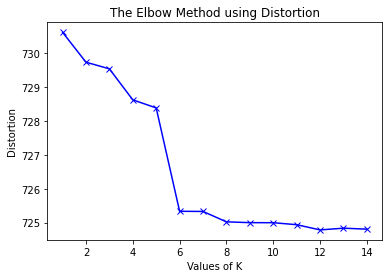

In [21]:

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

distortions = []
k_range = range(1,15)
for k in k_range:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(X_std)
    kmeanModel.fit(X_std)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    
plt.plot(k_range, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [176]:
kmeans_model = KMeans(n_clusters=len(GlobalVars.FOOD_GROUPS), random_state=0).fit(X_std)
kmeans_predicts = kmeans_model.predict(X_std)

kmeans_predicts

array([ 1,  1,  1,  1,  1, 16,  3,  1,  1, 16,  1,  1,  1,  1, 14,  1,  1,
        3, 16,  3,  3,  3,  3,  1,  3,  1,  1,  3, 16,  1,  1,  3,  1,  1,
       16,  3, 14,  3,  9,  1, 12,  3, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 15,  3,  9, 11, 15, 15, 15, 12,  3,  7, 15, 12, 15,  9,
       15, 15,  9, 15, 15, 15, 15, 15,  9, 15,  9, 15, 15,  9, 12, 16, 12,
       12,  3, 12, 12,  9,  3, 11, 16,  3, 15,  3,  9,  2,  3,  3,  3,  9,
        3,  3,  9, 12,  0,  3,  3,  2, 12, 12,  0, 12, 12, 12, 12, 12, 12,
        6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  0, 12,
       12, 12, 12, 12, 16, 12,  6, 12, 12,  0, 12, 12,  6, 12,  0, 12, 12,
       12, 12, 12, 12, 12, 12, 12,  0, 12, 12, 12, 16, 12, 12, 12,  0, 12,
       12, 12,  0, 11, 11,  0,  3,  0,  4,  4,  4, 14,  3,  3,  0,  0,  4,
        4,  4,  2,  2,  3,  3,  2,  1, 14, 14, 14,  1, 12, 14,  3, 14, 12,
       14, 14, 14,  3, 14

In [178]:
temp= defaultdict(list)
for r in zip(kmeans_predicts,Y):
  temp[r[0]].append(r[1])


In [182]:
def kmean_score():
  gi_high_food  =  dataset[(dataset['GI Category']==2)].sample()
  original_values = gi_high_food[GlobalVars.NUTRIENTS_COLUMNS].values
  label_values = Utils.apply_cutoff_labels(original_values[0])
  @timeit
  def f():
    af_prediction = kmeans_model.predict(original_values)
    return custom_model_score(label_values, temp[af_prediction[0]])
  b_results = baseline_model(label_values)
  print(sum([l[1] for l in b_results])/len(b_results))
  categorical_relavent(gi_high_food, b_results)
  a_results = f()
  print(sum([i[1] for i in a_results])/len(a_results))
  categorical_relavent(gi_high_food, a_results)

In [187]:
kmean_score()

Function baseline_model(array(['high', 'low', 'medium', 'medium', 'low', 'high', 'medium',
       'medium', 'low', 'low', 'low'], dtype='<U6'),) {} Took 0.0314 seconds
10.2
categorical score 0
Function f() {} Took 0.0205 seconds
4.8
categorical score 0


In [23]:
from sklearn.cluster import Birch
birch_model = Birch(n_clusters=None, compute_labels=True).fit(X_std)
birch_predicts = birch_model.predict(X_std)

In [24]:
temp = defaultdict(list)
for r in zip(birch_predicts,Y):
  temp[r[0]].append(r[1])

In [25]:
gi_high_food  =  dataset[(dataset['GI Category']==2)].sample()
original_values = gi_high_food[GlobalVars.NUTRIENTS_COLUMNS].values
label_values = Utils.apply_cutoff_labels(original_values[0])

In [26]:
gi_high_food

,Name,Group,Glycemic index,GI Category,Calories (kcal),Protein (g),Fats (g),Carbs (g),Net carbs (g),Sugar (g),...,Phenylalanine (mg),Valine (mg),Histidine (mg),Cholesterol (mg),Saturated Fat (g),Monounsaturated Fat (g),Polyunsaturated fat (g),Starch (g),Fructose (g),Trans Fat (g)
583,"Turnips, raw",vegetables,73.0,2,28,0.9,0.1,6.43,4.63,3.8,...,0.02,0.03,0.01,0.0,0.01,0.01,0.05,0.0,0.0,0.0


In [27]:
birch_prediction = birch_model.predict(original_values)

In [28]:
birch_prediction

array([136])

In [29]:
temp[birch_prediction[0]]

['Spices, tarragon, dried']

In [30]:
baseline_model(label_values)

Function baseline_model(array(['low', 'low', 'low', 'low', 'medium', 'medium', 'low', 'medium',
       'low', 'low', 'low'], dtype='<U6'),) {} Took 0.0324 seconds


array([['Onions, raw', 11],
       ['Squash, summer, zucchini, includes skin, raw', 11],
       ['Tomatoes, red, ripe, raw, year round average', 11],
       ['Peppers, sweet, green, raw', 11],
       ['Squash, summer, all varieties, raw', 11]], dtype=object)

In [31]:
custom_model_score(label_values, temp[birch_prediction[0]])

[('Spices, tarragon, dried', 3)]

In [202]:
n_neurons = 9   #9
m_neurons = 13  #13
som = MiniSom(n_neurons, m_neurons, X.shape[1], sigma=1.5, learning_rate=.5,
              activation_distance='euclidean',topology='hexagonal', 
              neighborhood_function='gaussian', random_seed=0)

som.pca_weights_init(X_std)
som.train(X_std, 1000, verbose=True)
print(som.quantization_error(X_std))
results = defaultdict(list)

for row in zip(X_std,Y):

    cluster = som.winner(row[0])
    results[cluster].append(row[1])

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.8048358877666656
0.8048358877666656


In [191]:
@timeit
def som_model_subs(food, som=som):
    std_values = scalar.transform(food)
    cluster =som.winner(std_values[0])
    return custom_model_score(label_values,results[cluster])

In [34]:
gi_high_food  =  dataset[(dataset['GI Category']==2)].sample()
original_values = gi_high_food[GlobalVars.NUTRIENTS_COLUMNS].values
label_values = Utils.apply_cutoff_labels(original_values[0])

In [35]:
gi_high_food

,Name,Group,Glycemic index,GI Category,Calories (kcal),Protein (g),Fats (g),Carbs (g),Net carbs (g),Sugar (g),...,Phenylalanine (mg),Valine (mg),Histidine (mg),Cholesterol (mg),Saturated Fat (g),Monounsaturated Fat (g),Polyunsaturated fat (g),Starch (g),Fructose (g),Trans Fat (g)
512,"Candies, gumdrops, starch jelly pieces",sweets,78.0,2,396,0.0,0.0,98.9,98.8,58.97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [192]:
res  = som_model_subs(original_values)

Function som_model_subs(array([[378.  ,   4.2 ,   2.7 ,  84.  ,   1.6 ,  45.42,  35.  ,  41.  ,
         31.  ,   0.67,   0.  ]]),) {} Took 0.0024 seconds


In [37]:
baseline_model(label_values)

Function baseline_model(array(['high', 'low', 'low', 'high', 'low', 'high', 'low', 'low', 'low',
       'low', 'low'], dtype='<U4'),) {} Took 0.0268 seconds


array([['Sugars, granulated', 11],
       ['Marmalade, orange', 11],
       ['Sweetener, syrup, agave', 11],
       ['Candies, taffy, prepared-from-recipe', 11],
       ['Candies, marshmallows', 11]], dtype=object)

In [190]:
custom_model_score(label_values, res)

[('Jams and preserves', 11),
 ('Marmalade, orange', 10),
 ('Syrups, maple', 9),
 ('Sweetener, syrup, agave', 10),
 ('Candies, marshmallows', 10)]

In [193]:
def som_score():
  gi_high_food  =  dataset[(dataset['GI Category']==2)].sample()
  original_values = gi_high_food[GlobalVars.NUTRIENTS_COLUMNS].values
  label_values = Utils.apply_cutoff_labels(original_values[0])
  b_results = baseline_model(label_values)
  print(sum([l[1] for l in b_results])/len(b_results))
  categorical_relavent(gi_high_food, b_results)
  a_results = som_model_subs(original_values)
  print(sum([i[1] for i in a_results])/len(a_results))
  categorical_relavent(gi_high_food, a_results)

In [198]:
som_score()

Function baseline_model(array(['high', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium',
       'medium', 'medium', 'low', 'low'], dtype='<U6'),) {} Took 0.0358 seconds
9.8
categorical score 5
Function som_model_subs(array([[2.500e+02, 1.628e+01, 1.119e+01, 2.089e+01, 1.400e+00, 3.640e+00,
        1.850e+02, 2.450e+02, 7.530e+02, 2.120e+00, 3.000e-02]]),) {} Took 0.0062 seconds
4.571428571428571
categorical score 6


In [205]:
def tune_som(n):
  som = MiniSom(n, n, X.shape[1], sigma=1.5, learning_rate=.5,
                activation_distance='euclidean',topology='hexagonal', 
                neighborhood_function='gaussian', random_seed=0)

  som.pca_weights_init(X_std)
  som.train(X_std, 1000, verbose=False)
  return som.quantization_error(X_std)

In [207]:
temp_q_error  = []
temp_t_error = []
temp_x =[]
temp_range = range(4,20)
for i in temp_range:
  q = tune_som(i)
  temp_q_error.append( q)
  # temp_t_error.append(t)

In [208]:
temp_sorted  = sorted(zip(temp_range,temp_q_error), key= lambda x: x[1])

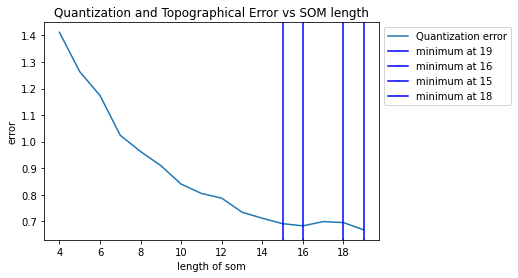

In [209]:
plt.plot(temp_range, temp_q_error, label = 'Quantization error')
# plt.plot(temp_range, temp_t_error, label = "Topographical error" )
for k in temp_sorted[:4]:
  plt.axvline(x = k[0], color = 'b', marker=",", label = 'minimum at %i'%k[0])
plt.title("Quantization and Topographical Error vs SOM length")
plt.xlabel("length of som")
plt.ylabel("error")
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

In [83]:
temp_sorted

[(4, 0.04483430799220273, 1.420870353702479),
 (15, 0.08576998050682261, 0.7235183763980568),
 (22, 0.08966861598440545, 0.6467441917658552),
 (27, 0.0935672514619883, 0.6134598571659676),
 (28, 0.10136452241715399, 0.6238180943297159),
 (19, 0.10331384015594541, 0.6784570410937748),
 (23, 0.10526315789473684, 0.6245220370913609),
 (10, 0.10526315789473684, 0.852210386758702),
 (24, 0.10916179337231968, 0.625037856040517),
 (25, 0.11500974658869395, 0.602291295533007),
 (18, 0.11500974658869395, 0.6899462726313866),
 (14, 0.11695906432748537, 0.7685870229103313),
 (20, 0.1189083820662768, 0.6505771130923488),
 (26, 0.12085769980506822, 0.6020436252278033),
 (17, 0.12085769980506822, 0.6922715624604816),
 (21, 0.12475633528265107, 0.6525344694933259),
 (13, 0.12475633528265107, 0.7304212982586458),
 (29, 0.1267056530214425, 0.5967245042176413),
 (16, 0.13450292397660818, 0.6937922204585357),
 (12, 0.14230019493177387, 0.7786100557536093),
 (11, 0.15204678362573099, 0.7781225631395509),


In [199]:
len(GlobalVars.FOOD_GROUPS)

17